### **Phishing Detection in Websites Using Stacked Ensemble Learning**

This notebook demonstrates a **stacked/blended ensemble learning approach** to detect phishing websites based on URL-based numeric predictors.

We use three main models—**Random Forest**, **XGBoost**, and **Logistic Regression**—combined in a multi-level architecture to achieve improved predictive performance.

The notebook walks through every step of the machine learning pipeline: data preprocessing, model training, meta-feature generation, ensemble stacking, evaluation, tuning, and improvement.

#### **1. Data Preparation**
**Objective:** To prepare the dataset for modeling by cleaning, scaling, and splitting it into training and testing sets.

**Concept**

Our dataset includes:
* **19 numeric predictors** such as URL length, and number of dots, hyphens, underscores, asterisks, etc. These capture structural and lexical aspects of website URLs.
* **Target variable:** `phishing` (0 = legitimate, 1 = phishing).

Before building models, we must ensure that the dataset is clean and suitable for numerical algorithms.

In [6]:
# Importing required libraries and packages

# Basic packages
import pandas as pd
import numpy as np

# For models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# For utilities
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Loading the dataset
df = pd.read_csv('Phishing Dataset - Websites.csv')

# Separating the features and the target
X = df.drop('phishing', axis=1)
y = df['phishing']

# Checking the structure of the dataset
print("Shape of the dataset: ", X.shape)
print("Target distribution:\n", y.value_counts())

Shape of the dataset:  (100077, 19)
Target distribution:
 phishing
0    63715
1    36362
Name: count, dtype: int64


In [10]:
# Handling missing values: replacing with median (robust against outliers)
X = X.fillna(X.median())

We normalise the numeric features using `StandardScaler`, since logistic regression requires scaled features for stability.

In [12]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We now divide the data into 80% training and 20% testing subsets using *stratified sampling* to preserve the class ratio.

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

All these steps ensure the data is consistent, normalised, and ready for model training.

#### **2. Base Learners (Level-1 Models)**

**Objective:** To define the **first-level (base) models** that will generate predictions used later by the meta-learner.

**Concept**

* A **stacked ensemble** combines multiple learning algorithms to leverage their individual strengths.
* Each base model learns independently, and their predictions are combined by a **meta-model** for improved accuracy.

**Chosen Base Models**
| Model | Role | Advantages |
|----------|----------|----------|
| Random Forest (RF) | Captures non-linear interactions and reduces overfitting through bagging | Robust and interpretable |
| Extreme Gradient Boosting (XGBoost) | Boosted tree ensemble focusing on hard-to-classify samples | Excellent for tabular data and handling imbalance |

We will later use their predicted probabilities as *meta-features* for the meta-learner.

In [16]:
# Initialising Random Forest and XGBoost as base learners
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.5, max_depth=6, subsample=0.8,
                          colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', random_state = 42))
]

#### **3. Generating Level-1 Predictions (Meta-Features)**

**Objective:** To create *meta-features* from base model predictions using **out-of-fold (OOF)** cross-validation.

**Concept**

* Directly training base models on the same data as the meta-learner can cause **information leakage**.
* To avoid this, we use **k-fold cross-validation**:
    * The dataset is split into *k* folds (e.g., 5).
    * For each fold:
        * The model is trained on *k−1* folds.
        * Predictions are made on the remaining fold.
* These OOF predictions form new training data for the meta-learner.

**Outcome**

We obtain:
* A training matrix (`meta_features_train`) of OOF predictions (each column = base model).
* A testing matrix (`meta_features_test`) containing average test predictions from all folds.

These are the input features for the **Level-2 meta-learner**.

In [18]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

for idx, (name, model) in enumerate(base_models):
    test_fold_preds = []
    print(f"\nTraining base model: {name.upper()}")

    for train_idx, valid_idx in kfold.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        val_pred = model.predict_proba(X_val)[:, 1]
        meta_features_train[valid_idx, idx] = val_pred

        # Predicting on test set for each fold
        test_pred = model.predict_proba(X_test)[:, 1]
        test_fold_preds.append(test_pred)

    # Averaging test predictions from each fold
    meta_features_test[:, idx] = np.mean(test_fold_preds, axis=0)


Training base model: RF

Training base model: XGB


#### **4. Training the Meta-Learner (Level-2 Model)**

**Objective:** To combine base model predictions using a meta-learner to produce the final phishing probability.

**Concept**
* The meta-learner learns optimal **weights** for combining base model predictions.
* We use **logistic regression** for simplicity and interpretability.
* It outputs a final probability between 0 and 1 indicating whether a website is likely phishing.

**Why Logistic Regression?**
* It is robust, simple, and interpretable (with the coefficients indicating model importance).
* It helps avoid overfitting that may arise in deeper meta-learners.

After training, this model becomes the final predictor in the stacked ensemble pipeline.

In [20]:
# Initialising logistic regression as the meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)
meta_learner.fit(meta_features_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### **5. Final Ensemble Predictions**

**Objective:** To generate final phishing predictions for the test dataset using the complete stacked model.

**Process**
1. Retraining the base models on the **entire training dataset**.
2. Generating test predictions (probabilities).
3. Feeding test predictions into the **trained logistic regression meta-learner**.
4. Obtaining final probabilities and converting them to binary labels using a threshold (usually 0.5).

**Interpretation**

* Probability ≥ 0.5 → classified as **phishing (1)**.
* Probability < 0.5 → classified as **legitimate (0)**.

This yields the final classification results for evaluation.

In [22]:
final_probs = meta_learner.predict_proba(meta_features_test)[:, 1]
final_preds = (final_probs >= 0.5).astype(int)

#### **6. Model Evaluation**

**Objective:** To quantitatively assess how well the ensemble detects phishing websites.

**Metrics**
| Metric | Description |
|----------|----------|
| Accuracy | Overall proportion of correct predictions |
| Precision | Fraction of predicted phishing URLs that were truly phishing |
| Recall (Sensitivity) | Fraction of actual phishing URLs that were correctly identified |
| F1-Score | Harmonic mean of precision and recall |
| ROC–AUC | Measures model’s ability to distinguish between classes |
| Confusion Matrix | Displays true/false positives and negatives |

For phishing detection, recall and ROC–AUC are crucial, since missing a phishing website (false negative) is costlier than a false alarm.


--- Ensemble Model Performance ---
Accuracy:  0.8941
Precision: 0.8694
Recall:    0.8339
F1-score:  0.8513
ROC-AUC:   0.9608


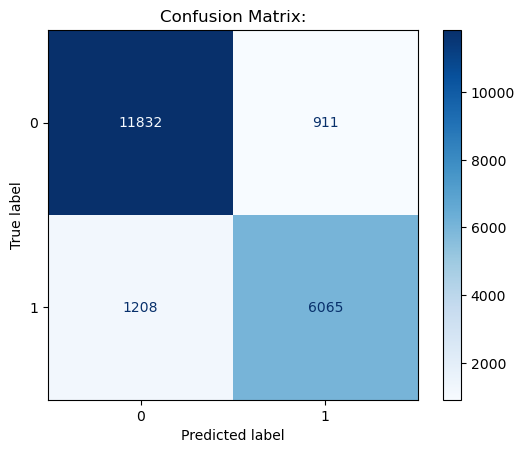

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

acc = accuracy_score(y_test, final_preds)
prec = precision_score(y_test, final_preds)
rec = recall_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)
roc = roc_auc_score(y_test, final_probs)
cm = confusion_matrix(y_test, final_preds)

print("\n--- Ensemble Model Performance ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")

# Visualising the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=meta_learner.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix:')
plt.show()

#### **7. Model Optimisation and Validation**

**Objective:** To improve model performance through hyperparameter tuning of base models.

**Concept**

* Machine learning models depend heavily on hyperparameters.
* We use **GridSearchCV** to systematically explore parameter combinations and find the best-performing settings.
* For Random Forest:
    * `n_estimators` (number of trees)
    * `max_depth` (tree depth)
    * `max_features` (number of features considered per split)

This ensures the model generalises better and avoids overfitting.

In [26]:
# Obtaining the best hyperparameters for RF
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 12, 16],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid = param_grid_rf,
    cv=3,
    scoring = 'roc_auc',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Best RF parameters: ", grid_rf.best_params_)

Best RF parameters:  {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 300}


#### **8. Model Improvement with Tuned Random Forest**

**Objective:** To integrate the **optimised Random Forest parameters** into the stacked ensemble and retrain all components for improved accuracy.

**Concept**

After tuning, the Random Forest base model becomes more robust. It reduces variance, learns deeper patterns, and produces better meta-features for the meta-learner.

**Steps**

* Retraining Random Forest with best hyperparameters (`n_estimators`, `max_depth`, `max_features`).
* Rebuilding the stacked ensemble, using tuned Random Forest + existing XGBoost.
* Regenerating meta-features via cross-validation.

In [28]:
best_params_rf = grid_rf.best_params_

# Retraining RF with best parameters
rf_best = RandomForestClassifier(
    n_estimators = best_params_rf['n_estimators'],
    max_depth = best_params_rf['max_depth'],
    max_features = best_params_rf['max_features'],
    random_state=42
)

# Keeping XGB parameters as before
xgb_best = XGBClassifier(
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state=42
)

# Updated base model list
base_models_tuned = [
    ('rf_best', rf_best),
    ('xgb_best', xgb_best)
]

We repeat the **out-of-fold (OOF)** meta-feature generation process, but now using the tuned Random Forest and previous XGBoost models. This ensures the meta-learner learns from **improved base predictions**.

In [34]:
meta_features_train_tuned = np.zeros((X_train.shape[0], len(base_models_tuned)))
meta_features_test_tuned = np.zeros((X_test.shape[0], len(base_models_tuned)))

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for idx, (name, model) in enumerate(base_models_tuned):
    test_fold_preds = []
    print(f"\nTraining tuned base model: {name.upper()}")
    
    for train_idx, valid_idx in kfold.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model.fit(X_tr, y_tr)
        val_pred = model.predict_proba(X_val)[:, 1]
        meta_features_train_tuned[valid_idx, idx] = val_pred
        
        test_pred = model.predict_proba(X_test)[:, 1]
        test_fold_preds.append(test_pred)
    
    meta_features_test_tuned[:, idx] = np.mean(test_fold_preds, axis=0)


Training tuned base model: RF_BEST

Training tuned base model: XGB_BEST


Logistic regression again acts as the Level-2 model. It learns the best combination weights for the tuned base model outputs.

In [37]:
# Retraining the logistic regression model as meta-learner
meta_learner_tuned = LogisticRegression(max_iter=1000, random_state=42)
meta_learner_tuned.fit(meta_features_train_tuned, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Now, we compute the same performance metrics again. Typically, we should observe an increase in ROC–AUC and Recall, indicating enhanced phishing detection capability.


--- Improved Stacked Ensemble Performance (Tuned RF) ---
Accuracy:  0.8934
Precision: 0.8625
Recall:    0.8408
F1-score:  0.8515
ROC-AUC:   0.9613


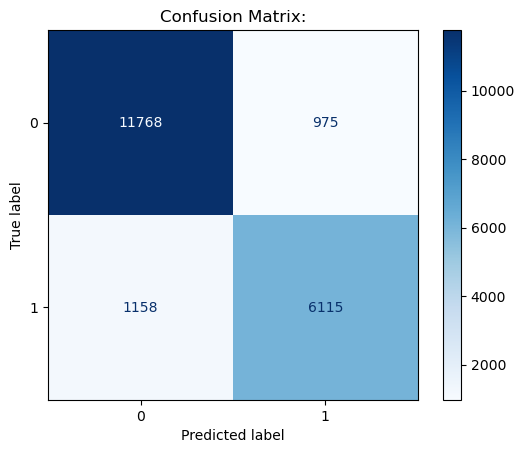

In [42]:
# Generating final predictions
final_probs_tuned = meta_learner_tuned.predict_proba(meta_features_test_tuned)[:, 1]
final_preds_tuned = (final_probs_tuned >= 0.5).astype(int)

# Evaluating performance
acc_tuned = accuracy_score(y_test, final_preds_tuned)
prec_tuned = precision_score(y_test, final_preds_tuned)
rec_tuned = recall_score(y_test, final_preds_tuned)
f1_tuned = f1_score(y_test, final_preds_tuned)
roc_tuned = roc_auc_score(y_test, final_probs_tuned)
cm_tuned = confusion_matrix(y_test, final_preds_tuned)

print("\n--- Improved Stacked Ensemble Performance (Tuned RF) ---")
print(f"Accuracy:  {acc_tuned:.4f}")
print(f"Precision: {prec_tuned:.4f}")
print(f"Recall:    {rec_tuned:.4f}")
print(f"F1-score:  {f1_tuned:.4f}")
print(f"ROC-AUC:   {roc_tuned:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=meta_learner_tuned.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix:')
plt.show()

#### **9. Feature Importance**

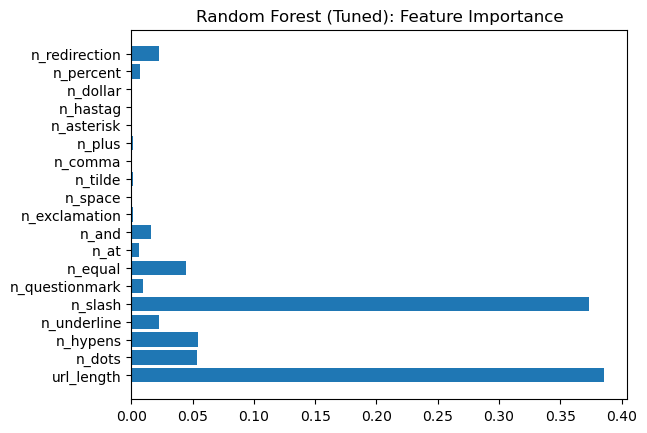

In [33]:
import matplotlib.pyplot as plt

importances = base_models_tuned[0][1].feature_importances_
plt.barh(df.columns[:-1], importances)
plt.title("Random Forest (Tuned): Feature Importance")
plt.show()

#### **10. SHAP for Explainability**

In [ ]:
%pip install shap

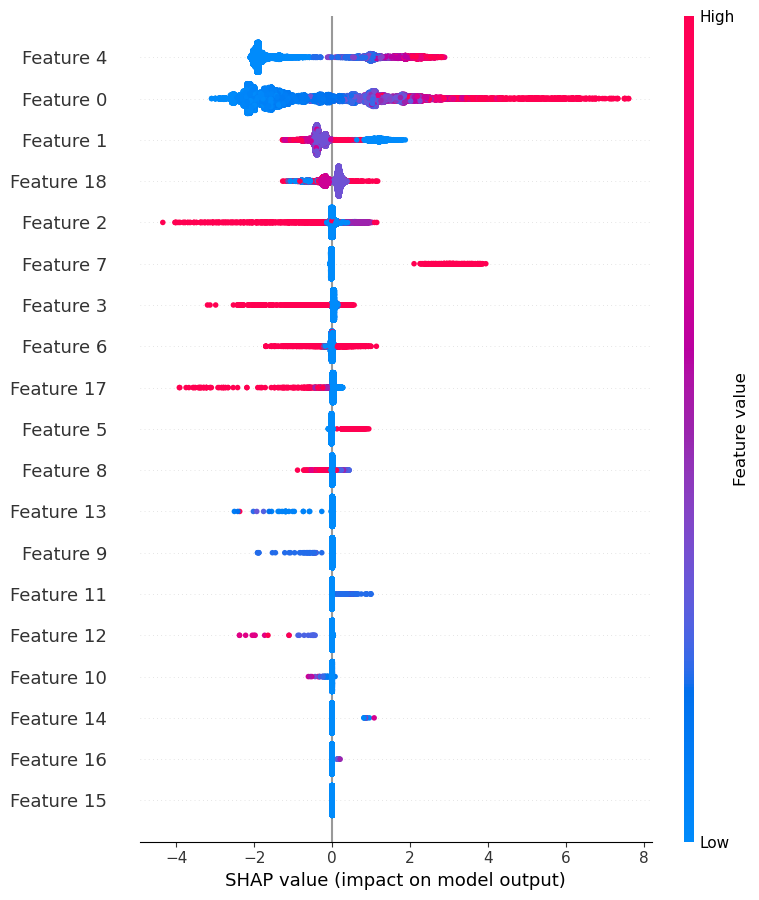

In [39]:
import shap

explainer = shap.Explainer(base_models_tuned[1][1])
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

#### **Conclusions**
1. **Stacking** leverages the diversity of multiple models for superior prediction.
2. **Cross-validation** ensures robust, leak-free meta-features.
3. **Hyperparameter** tuning improves model accuracy and stability.
4. **Evaluation metrics** (especially Recall and ROC–AUC) are essential for reliable phishing detection.